In [1]:
#import CMZoom_utility as cmz
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astrodendro
import os
from astropy import wcs
from astrodendro import Dendrogram, pp_catalog
from astrodendro.analysis import PPStatistic
from astropy.table import Table, hstack, Column
from astropy.utils.console import ProgressBar
import reproject
import pyregion
from matplotlib import rc
import CMZoom_utility as cmz
import imf


#rc('font', **{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)
print(np.__version__)
import aplpy

1.16.5


In [2]:
catalog = Table.read('/Users/hph/cmzoom_catalog/catalog_acc/catalog_acc.fits')
massmin = min(catalog['mass'])
massmax = max(catalog['mass'])
massbins = np.logspace(np.log10(massmin), np.log10(massmax),15)
print(massbins)
mass_edges = np.array([  0.16267013,   4.49511251,   8.82757115,  13.16001353,  17.49245591,
  21.82491455,  26.15735693,  30.48979931,  34.82225795,  39.15470033,
  43.48714271,  47.81960135,  52.15204373,  56.48448611,  60.81694475,
  65.14938713,  69.48182951,  73.81428815,  78.14673053,  82.47917291,
  86.81163155,  91.14407393,  95.47651631,  99.80897495, 104.14141733,
 108.47385971, 112.80631835, 117.13876073, 121.47120311, 125.80366175,
 130.13610413,200,300,400,500,600,700,800,900,1000,1e4])
found_avg = np.flip(np.array([.95,.95,.95,.95,.95,.95,.95,.95,.95,.95,   .95,    .95,    .95,   .95,    .95,    .95,    .95,    .95,    0.98,  0.98,  0.94,  0.94,
                      0.9,   0.9,   0.82,  0.68,  0.58,  0.4,   0.34,  0.28,  0.1,   0.08,  0.,    0.,    0.,
                      0.,    0.,    0.,    0.,    0.,    0.,  ]))

[3.68613498e+00 7.49746344e+00 1.52495659e+01 3.10170580e+01
 6.30875593e+01 1.28317783e+02 2.60993668e+02 5.30851556e+02
 1.07973261e+03 2.19613655e+03 4.46686126e+03 9.08543209e+03
 1.84794359e+04 3.75864953e+04 7.64495539e+04]


In [3]:
#### Make IMF figure
sfe=0.75
lim_vals = mass_edges#massbins
percent_has_massive_avg = np.zeros(len(lim_vals))
num_massive_avg = np.zeros(len(lim_vals))
for j in range(len(lim_vals)):
    print(j)
    has_massive = np.zeros(1000)
    num_massive = np.zeros(1000)
    for i in range(1000):
        num_massive[i]=len(np.where(imf.make_cluster(sfe*lim_vals[j],silent=True)>8)[0])
        if num_massive[i]>0: has_massive[i]=1
    percent_has_massive_avg[j]=has_massive.sum()/1000
    num_massive_avg[j] = num_massive.sum()/1000

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


In [122]:
### The percentage of leaves missed in each mass bin:
### (specially tuned to above massbins, by eye from simobs percent plot)
#percent_array=np.array([0.1, 0.1, 0.2, 0.5, 0.8, .95, .95, .95, .95, .95, .95, .95, .95, .95, .95])
percent_array=found_avg
percent_array[percent_array>0.95]=0.95
print("The percent detected array: "+str(percent_array), "which has length: "+str(len(percent_array)))
missed = np.ones_like(percent_array)-percent_array
print("The percent detected array: "+str(percent_array), "which has length: "+str(len(percent_array)))

The percent detected array: [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.08 0.1  0.28 0.34 0.4
 0.58 0.68 0.82 0.9  0.9  0.94 0.94 0.95 0.95 0.95 0.95 0.95 0.95 0.95
 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95] which has length: 41
The percent detected array: [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.08 0.1  0.28 0.34 0.4
 0.58 0.68 0.82 0.9  0.9  0.94 0.94 0.95 0.95 0.95 0.95 0.95 0.95 0.95
 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95] which has length: 41


In [123]:
masshist = np.histogram(catalog['mass'],bins=mass_edges)#massbins)
#print(massbins)
print(masshist[0])
print(len(mass_edges))
ntest = 30
print(mass_edges[ntest])
print(masshist[0][ntest])
print(missed[ntest])
print(missed[ntest]*masshist[0][ntest])


[ 1  7 13 14 14 14 10  8 10 11  6 11  5  3  7  4  4  4  3  4  3  4  3  6
  4  0  3  4  7  1 31 16  7  4  2  3  2  4  0 26]
41
130.13610413
31
0.050000000000000044
1.5500000000000014


In [124]:
print("%2.2e"%np.sum(catalog['mass'][catalog['mask_num']==9]))

1.82e+05


6.870000000000006


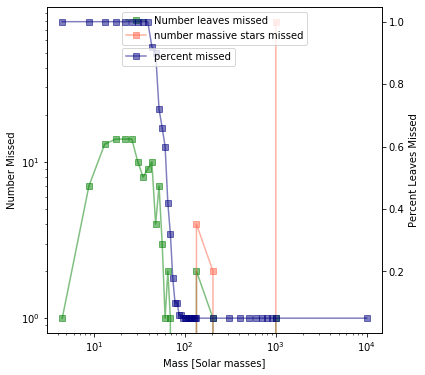

In [125]:
#######################################################################
### IMF missed source detection upper limit:
#######################################################################
plt.close()
catalog = Table.read('/Users/hph/cmzoom_catalog/catalog_acc/catalog_acc.fits')
#percent_array=np.array([0.1, 0.1, 0.2, 0.5, 0.8, .95, .95, .95, .95, .95, .95, .95, .95, .95, .95])
#percent_array=np.array([0.1, 0.1, 0.2, 0.5, 0.8, .95, .99, .99, .99, .99, .99, .99, .99, .99, .99])
percent_array=found_avg
missed = np.ones_like(percent_array)-percent_array
num_massive_avg1 = np.rint(num_massive_avg)
missed_massive = missed*num_massive_avg1
print(sum(missed_massive))

num_missed = np.rint(missed[1:]*masshist[0])
missed_massive_array = num_missed*num_massive_avg1[1:]
total_massive_missed= sum(missed_massive)

mass_cens = mass_edges + (mass_edges[1]-mass_edges[0])

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(6,6),facecolor='white')
axp = ax.twinx()
ax.plot(mass_cens[:-1],num_missed,color='green',label='Number leaves missed',marker='s',alpha=0.5)
#ax.plot(massbins,num,color='k',label='number leaves missed')
axp.plot(mass_cens,missed,color='navy',label='percent missed',marker='s',alpha=0.5)
ax.plot(mass_cens[:-1],missed_massive_array,color='tomato',label='number massive stars missed',
        marker='s',alpha=0.5)

ax.set_ylabel('Number Missed')
ax.set_xlabel('Mass [Solar masses]')
ax.legend(loc='upper center')
axp.legend(loc=(0.225,0.82))
axp.set_ylabel('Percent Leaves Missed')
ax.set_xscale("log")
ax.set_yscale('log')
#ax.set_ylim(0.1,100)
#axp.set_ylim(0.,1)

plt.show()

In [126]:
print(mass_edges[1]-mass_edges[0])
print(mass_edges[18])

4.33244238
78.14673053


In [127]:

#num_massive_avg1 = num_massive_avg
#num_massive_avg1[num_massive_avg<1]=0
#num_missed = np.rint(missed[:-1]*masshist[0])
#missed_massive_array = num_missed*num_massive_avg1[:-1]

print("number leaves missed:")
print(num_missed)
print("number of massive stars for each mass bin:")
print(num_massive_avg1)
print("number of missed massive stars in each mass bin:")
print(missed_massive)
print("total number missed massive stars" )
print(sum(missed_massive))
print("percent ")
print(total_massive_missed/sum(num_massive_avg))

number leaves missed:
[ 1.  7. 13. 14. 14. 14. 10.  8.  9. 10.  4.  7.  3.  1.  2.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  1.  0.  0.  0.  0.
  0.  0.  0.  1.]
number of massive stars for each mass bin:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  3.  4.  5.
  5.  6.  7.  8. 79.]
number of missed massive stars in each mass bin:
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.1  0.1  0.06 0.06 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.1  0.1  0.15 0.2  0.25 0.25 0.3  0.35 0.4  3.95]
total number missed massive stars
6.870000000000006
percent 
0.05096817271310933


In [4]:
##########################################################################
### total sf in CMZ for all leaves
### assuming all leaves collapse on a freefall time
### and form stars with efficiency "sfe"
##########################################################################
sfe = 0.1
stars_per_year = 0
starmass_per_year = 0
freefreefrac = 0.5
for i in range(len(catalog['mass'])):
    if catalog['mask_num'][i]==9:
        cluster_for_leafi = imf.make_cluster(catalog['mass'][i]*sfe*freefreefrac,silent=True,massfunc='kroupa')
    else:
        cluster_for_leafi = imf.make_cluster(catalog['mass'][i]*sfe,silent=True,massfunc='kroupa')
    num_stars_for_leafi = len(cluster_for_leafi)
    starmass_for_leafi = sum(cluster_for_leafi)
    stars_per_yeari = num_stars_for_leafi/catalog['tff'][i]
    starmass_per_yeari = starmass_for_leafi/catalog['tff'][i]
    stars_per_year += stars_per_yeari
    starmass_per_year += starmass_per_yeari
print("SFR over freefall time for each leaf")
print("Stars per year: %2.2f"%stars_per_year)
print("SFR: %2.2f msun per year"%starmass_per_year)


SFR over freefall time for each leaf
Stars per year: 2.55
SFR: 1.07 msun per year


In [29]:
##########################################################################
### total sf in CMZ for selection of leaves (currently exluding SgrB2)
### assuming all leaves collapse on a freefall time
### and form stars with efficiency "sfe"
### EXCLUDING SGR B2
##########################################################################
sfe = 0.1
cc = (catalog['mask_num']!=9)# & (catalog['mask_num']!=27)
stars_per_year = 0
starmass_per_year = 0
for i in range(len(catalog['mass'][cc])):
    cluster_for_leafi = imf.make_cluster(catalog['mass'][cc][i]*sfe,silent=True,massfunc='kroupa')
    num_stars_for_leafi = len(cluster_for_leafi)
    starmass_for_leafi = sum(cluster_for_leafi)
    stars_per_yeari = num_stars_for_leafi/catalog['tff'][cc][i]
    starmass_per_yeari = starmass_for_leafi/catalog['tff'][cc][i]
    stars_per_year += stars_per_yeari
    starmass_per_year += starmass_per_yeari
print("SFR over freefall time of each non-sgrb2 leaves")
print("Stars per year: %2.2f"%stars_per_year)
print("Mass of stars per year: %2.2f"%starmass_per_year)

SFR over freefall time of each non-sgrb2 leaves
Stars per year: 0.15
Mass of stars per year: 0.06


In [35]:
##########################################################################
### total sf in CMZ for selection of leaves (currently exluding SgrB2)
### assuming all leaves collapse on a freefall time
### and form stars with efficiency "sfe"
### Special Treatment for SGR B2
##########################################################################
cfrac = 0.2
sfe = 0.1
imftype='kroupa'
stars_per_year = 0
starmass_per_year = 0
for i in range(len(catalog['mass'])):
    if catalog['leaf_ID'][i]=='G0.699-0.028a':
        sgrb2_N_mass = 27897.0
        cluster_for_leafi== imf.make_cluster(cfrac*sgrb2_N_mass*sfe,silent=True,massfunc=imftype)
    elif catalog['leaf_ID'][i]=='G0.699-0.028b':
        sgrb2_M_mass = 9572.0
        cluster_for_leafi = imf.make_cluster(cfrac*sgrb2_M_mass*sfe,silent=True,massfunc=imftype)
    elif catalog['mask_num'][i]==9:
        cluster_for_leafi = imf.make_cluster(cfrac*catalog['mass_bgsub'][i]*sfe,silent=True,massfunc=imftype)
    else:
        cluster_for_leafi = imf.make_cluster(cfrac*catalog['mass'][i]*sfe,silent=True,massfunc=imftype)
    num_stars_for_leafi = len(cluster_for_leafi)
    starmass_for_leafi = sum(cluster_for_leafi)
    stars_per_yeari = num_stars_for_leafi/catalog['tff'][i]
    starmass_per_yeari = starmass_for_leafi/catalog['tff'][i]
    stars_per_year += stars_per_yeari
    starmass_per_year += starmass_per_yeari
print("SFR over freefall time of all leaves")
print("Stars per year: %2.2f"%stars_per_year)
print("Mass of stars per year: %2.2f"%starmass_per_year)

SFR over freefall time of all leaves
Stars per year: 0.17
Mass of stars per year: 0.06


/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app


catalog.keys()

In [14]:
##########################################################################
### total sf in CMZ for all leaves over 200,000 yr timescale
### assuming all leaves collapse over mean freefall time
### and form stars with efficiency "sfe"
##########################################################################
sfe = 0.1
stars_per_year = 0
starmass_per_year = 0
for i in range(len(catalog['mass'])):
    cluster_for_leafi = imf.make_cluster(catalog['mass'][i]*sfe,silent=True,massfunc='kroupa')
    num_stars_for_leafi = len(cluster_for_leafi)
    starmass_for_leafi = sum(cluster_for_leafi)
    stars_per_yeari = num_stars_for_leafi/catalog['tff'].mean()
    starmass_per_yeari = starmass_for_leafi/catalog['tff'].mean()
    stars_per_year += stars_per_yeari
    starmass_per_year += starmass_per_yeari
print("SFR over mean freefall time of leaves")
print("Stars per year: %2.2f"%stars_per_year)
print("SFR: %2.2f msun per year"%starmass_per_year)

SFR over mean freefall time of leaves
Stars per year: 0.67
SFR: 0.29 msun per year


In [31]:
##########################################################################
### total sf in CMZ for all leaves over 200,000 yr timescale
### assuming all leaves collapse over mean freefall time
### and form stars with efficiency "sfe"
### EXCLUDING SGR B2
##########################################################################
sfe = 0.75
cc = (catalog['mask_num']!=9)# & (catalog['mask_num']!=27)
stars_per_year = 0
starmass_per_year = 0
for i in range(len(catalog['mass'][cc])):
    cluster_for_leafi = imf.make_cluster(catalog['mass'][cc][i]*sfe,silent=True,massfunc='kroupa')
    num_stars_for_leafi = len(cluster_for_leafi)
    starmass_for_leafi = sum(cluster_for_leafi)
    stars_per_yeari = num_stars_for_leafi/catalog['tff'][cc].mean()
    starmass_per_yeari = starmass_for_leafi/catalog['tff'][cc].mean()
    stars_per_year += stars_per_yeari
    starmass_per_year += starmass_per_yeari
print("SFR over mean freefall time of all leaves")
print("Stars per year: %2.2f"%stars_per_year)
print("SFR: %2.2f msun per year"%starmass_per_year)

SFR over mean freefall time of all leaves
Stars per year: 0.74
SFR: 0.30 msun per year


In [25]:
##########################################################################
### total sf in CMZ for all leaves over 200,000 yr timescale
### assuming all leaves collapse over mean freefall time
### and form stars with efficiency "sfe"
### with special treatment for SGR B2
##########################################################################
sfe = 0.75
stars_per_year = 0
starmass_per_year = 0
for i in range(len(catalog['mass'])):
    if catalog['leaf_ID'][i]=='G0.699-0.028a':
            sgrb2_N_mass = 27897.0
            cluster_for_leafi== imf.make_cluster(sgrb2_N_mass*sfe,silent=True,massfunc=imftype)
    elif catalog['leaf_ID'][i]=='G0.699-0.028b':
        sgrb2_M_mass = 9572.0
        cluster_for_leafi = imf.make_cluster(sgrb2_M_mass*sfe,silent=True,massfunc=imftype)
    elif catalog['mask_num'][i]==9:
        cluster_for_leafi = imf.make_cluster(catalog['mass_bgsub'][i]*sfe,silent=True,massfunc=imftype)
    else:
        cluster_for_leafi = imf.make_cluster(catalog['mass'][i]*sfe,silent=True,massfunc=imftype)
    num_stars_for_leafi = len(cluster_for_leafi)
    starmass_for_leafi = sum(cluster_for_leafi)
    stars_per_yeari = num_stars_for_leafi/catalog['tff'].mean()
    starmass_per_yeari = starmass_for_leafi/catalog['tff'].mean()
    stars_per_year += stars_per_yeari
    starmass_per_year += starmass_per_yeari
print("SFR over mean freefall time of all leaves")
print("Stars per year: %2.2f"%stars_per_year)
print("SFR: %2.2f msun per year"%starmass_per_year)    
        

SFR over mean freefall time of all leaves
Stars per year: 1.50
SFR: 0.64 msun per year


/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  del sys.path[0]


In [7]:
print("%2.2e"%catalog['tff'].mean())

7.48e+04


In [11]:
##########################################################################
### total sf in CMZ for all leaves
### assuming all leaves collapse on a freefall time
### and form stars with efficiency "sfe"
##########################################################################
sfe = 0.3
stars_array = np.zeros(len(catalog['tff']))
starmass_array = np.zeros(len(catalog['tff']))
stars_cum = np.zeros(len(catalog['tff']))
starmass_cum = np.zeros(len(catalog['tff']))
t_array = np.sort(catalog['tff'])
sinds = np.argsort(catalog['tff'])
for i in range(len(catalog['mass'])):
    cluster_for_leafi = imf.make_cluster(catalog['mass'][sinds[i]]*sfe,silent=True,massfunc='kroupa')
    num_stars_for_leafi = len(cluster_for_leafi)
    starmass_for_leafi = sum(cluster_for_leafi)
    
    stars_array[i]=num_stars_for_leafi
    starmass_array[i]=starmass_for_leafi
    if i==0:
        stars_cum[i] = num_stars_for_leafi
        starmass_cum[i] = starmass_for_leafi
    else:
        stars_cum[i] = stars_cum[i-1]+num_stars_for_leafi
        starmass_cum[i] = starmass_cum[i-1]+starmass_for_leafi
print('Done')


Done


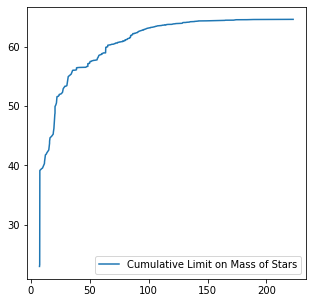

In [128]:
f = plt.figure(figsize=(5,5))

ax = f.add_subplot(111)
ax.plot(t_array/1e3,starmass_cum/1e3,label='Cumulative Limit on Mass of Stars')
ax.legend(loc='best')
ax.set_yscale('linear')

In [136]:
catalog = Table.read('/Users/hph/cmzoom_catalog/catalog_acc/catalog_acc.fits')
print(np.sum(catalog['mass'][catalog['mask_num']==9]))

182292.66837346353


In [30]:
print(sum(catalog['mass'][catalog['mask_num']!=9]))
sum(catalog['mass'][catalog['mask_num']==9])

33217.445911989336


182292.66837346356

In [134]:
print('%2.2e'%(243492.43982168904-215510.1142854529))

2.80e+04


In [138]:
print('%2.2f'%((215510.1142854529-195745.4083123633)/215510.1142854529))



0.09
